In [12]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.dates import DateFormatter, MonthLocator
from wordcloud import WordCloud
from nltk.stem import PorterStemmer


# Opinion Leaders 500e: Articles & Youtube Video Transcripts

In [13]:
opinionLeaders500_original = pd.read_csv('500e - Opinion Leaders.csv')
opinionLeaders500 = opinionLeaders500_original.copy()

opinionLeaders500 = opinionLeaders500.drop(columns=['Date', 'Title', 'Channel Name'])

# Download necessary NLTK data files for tokenisation and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/janapawlenczuk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janapawlenczuk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/janapawlenczuk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

/Users/janapawlenczuk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


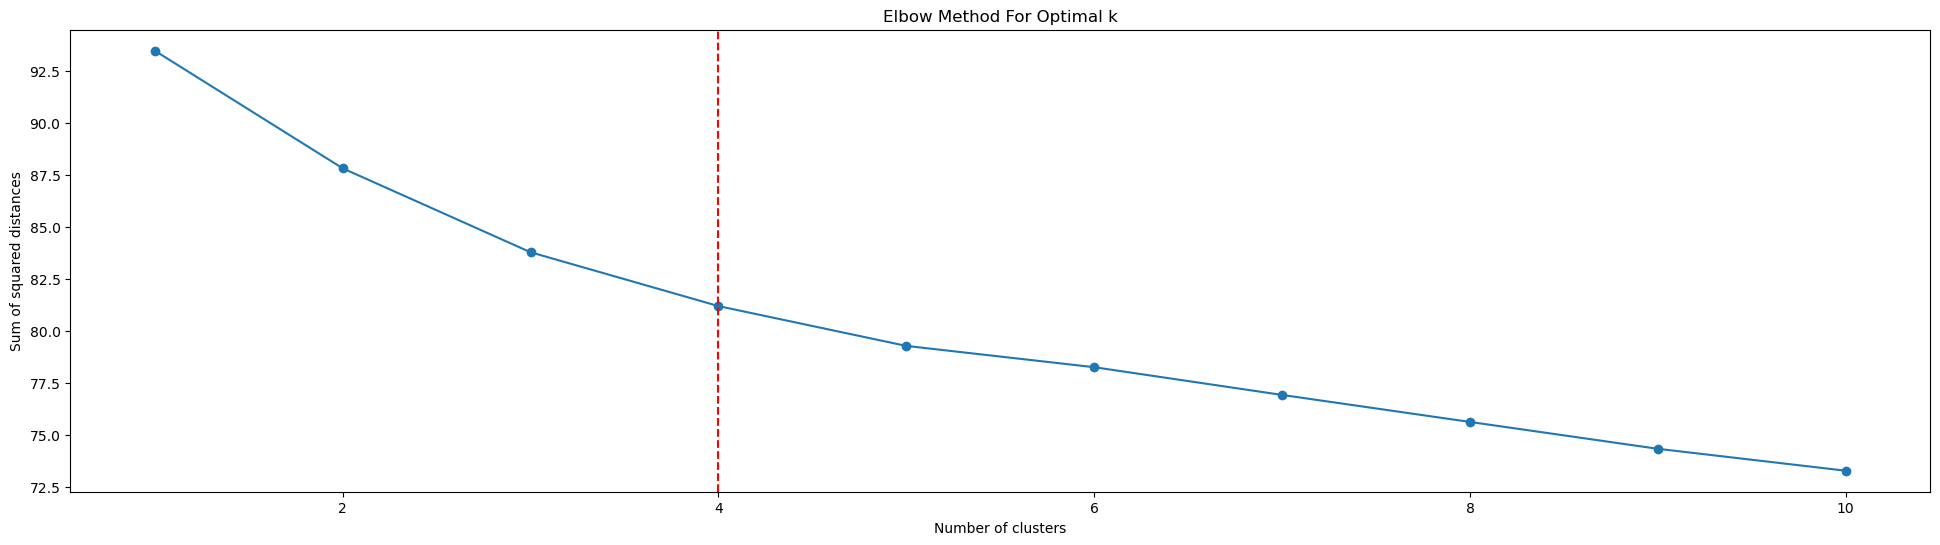


Cluster 0 Top Keywords:
city, drive, driving, charging, little, back, battery, small, range, electric

Cluster 0 Top Negative Words:
currently, korea, yet, pickup, powertrain, lot, saw, hybrid, veloster, kia

Cluster 0 Key Articles:
- Fiat made the 2013 500e specifically for the U.S. market and even said that it had no intentions to sell that vehicle in Europe, leaving its fans at home, in Italy, with tears in their eyes. The 500 was so successful that the Italian automaker couldn’t replace it with anything else. Moreover, it expanded the range using the same nameplate and various letters behind it. While the L or X meant larger-sized vehicles, with a crossover stance or an MPV, respectively, the e stood for electric.  Below the bumper, the 500e sported a different apron than its siblings. It featured a trapezoidal grille with an upper gap and round holes. The fog lamps were also included in this new part. Depending on the trim level, the car featured contrasting colors for the door m

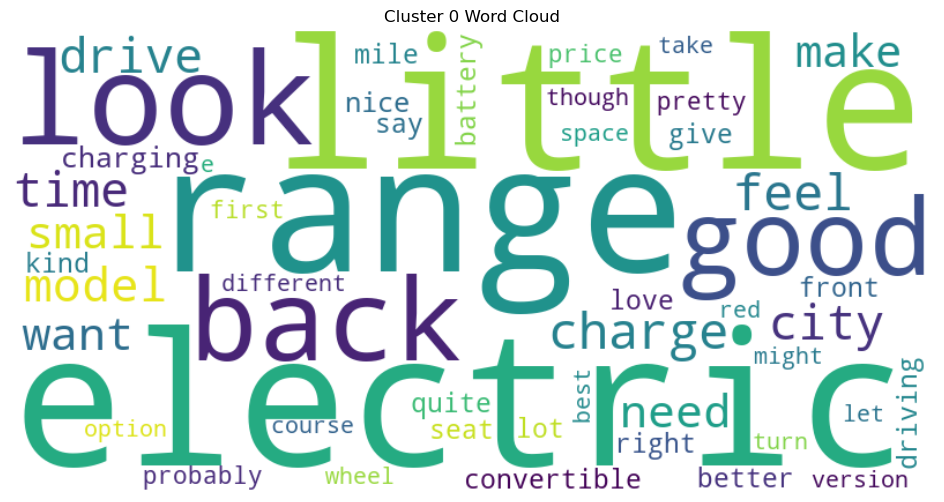


Cluster 0 Sample Articles:
0    Fiat made the 2013 500e specifically for the U...
1    Save Money. Use the U.S. News Best Price Progr...
5    \n\t\t\tYour contribution is appreciated.\t\t ...
Name: Text, dtype: object


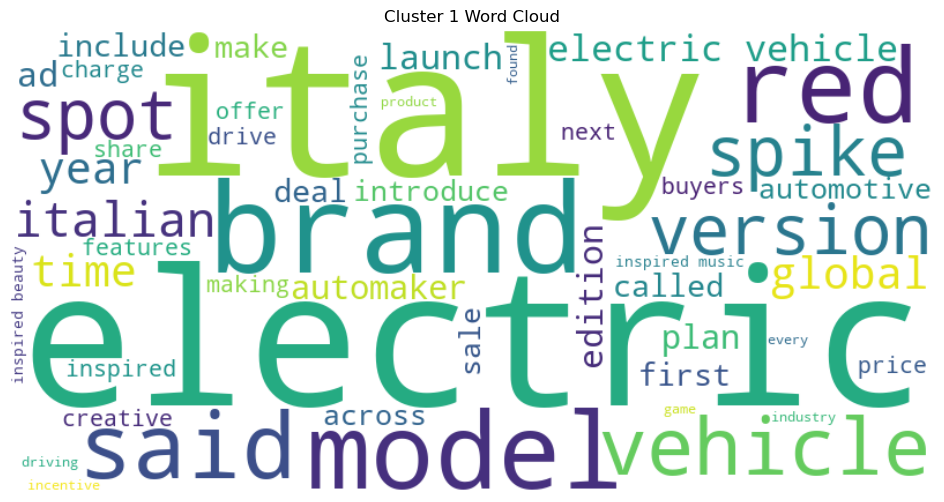


Cluster 1 Sample Articles:
3    The Fiat 500e not only offers the lowest MSRP ...
4    See also: FIAT 500e: Electric Icon Arrives in ...
7    MIAMI – It's been hard times for Fiat fans. Th...
Name: Text, dtype: object


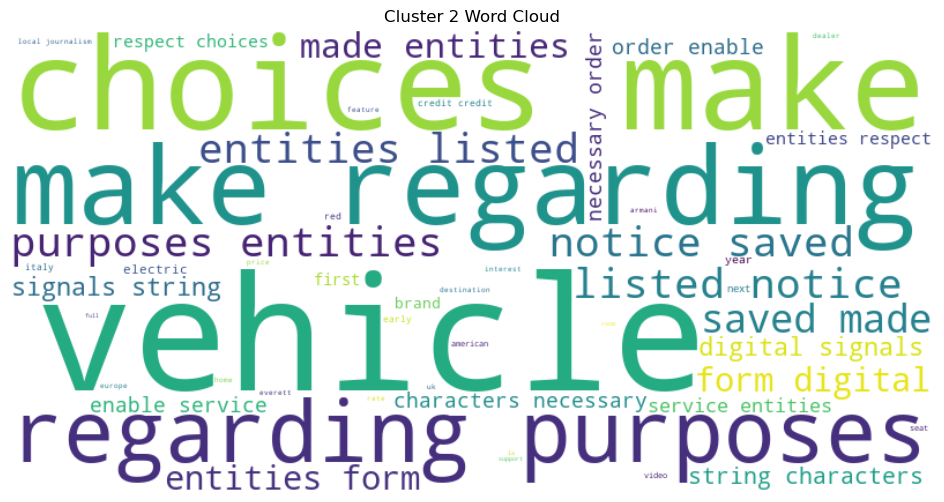


Cluster 2 Sample Articles:
2     2024 Fiat 500e (Photo provided by Fiat) La Dol...
11    " The 2024 Fiat 500e has two qualities that co...
26    La Dolce Vita Meets the American Dream: FIAT B...
Name: Text, dtype: object


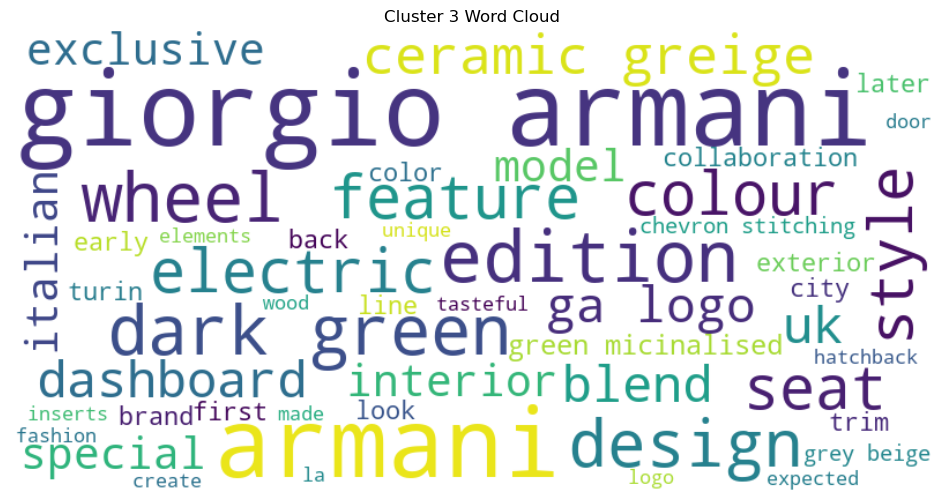


Cluster 3 Sample Articles:
6      The exterior is devoid of any chrome trimming...
10    \nProduced at the Fiat Mirafiori plant in Turi...
14    Fiat 500e Giorgio Armani in Dark Green  Billed...
Name: Text, dtype: object


In [14]:
# Load the dataset
opinionLeaders500 = pd.read_csv('500e - Opinion Leaders.csv')

# Drop irrelevant columns
opinionLeaders500 = opinionLeaders500.drop(columns=['Date', 'Title', 'Channel Name'])

# Update stopwords handling
custom_stopwords = set(stopwords.words('english'))
additional_stopwords = ['car', 'cars', 'fiat', 'jeep', 'hyundai', 'kona', 'stellantis', 'market', 'available',
    'would', 'also', 'new', 'level', 'like', 'even', 'according', 'offered', 'move',
    'one', 'content', 'information', 'interests', 'activity', 'mean', 'go', 'quit',
    'got', 'much', 'actual', 'thing', 'bit', 'see', 'think', 'yeah', 'know', 'and', 
    'way', 'come', 'presented', 'example', 'esposito', 'lee', 'torque', 'ready', 
    'since', 'still', 'two', 'sold', 'week', 'sherpa', 'around', 'use', 'um', 
    'together', 'us', 'really', 'america', 'well', 'mirafiori', 'campaign', 'north',
    'sales', 'bag', 'says', 'get', 'world', 'germani', 'belgium', 'spain', 'ev', 'evs',
    'uh', 'oh', 'im', 'thats', 'youre', 'weve', 'dont', 'actually', 'ahmed', 'work', 'reuters','youve','there','going',
    'gelateria', 'list', 'required', 'instead', 'added', 'inbox', 'honda', 'help', 'dedicated',
    'inform', 'news', 'group', 'report', 'couldnt', 'three', 'including', 'however', 'people'
]
custom_stopwords.update(additional_stopwords)

# Define preprocessing function
def preprocess(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
        return ' '.join(tokens)
    else:
        return ''

# Preprocess the text data
opinionLeaders500['cleaned_text'] = opinionLeaders500['Text'].apply(preprocess)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(opinionLeaders500['cleaned_text'])

# Determine the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(24, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.axvline(x=4, color='red', linestyle='--')  
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

# Apply KMeans Clustering with optimal clusters determined by Elbow Method
optimal_k = 4  # Optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add the cluster labels
opinionLeaders500['Cluster'] = clusters

# Add sentiment analysis
sid = SentimentIntensityAnalyzer()
opinionLeaders500['Sentiment'] = opinionLeaders500['Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Function to get top keywords in each cluster
def get_top_keywords(data, clusters, labels, n_terms=10):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    terms = labels
    top_keywords = {}
    for i, r in df.iterrows():
        top_keywords[i] = [terms[t] for t in np.argsort(r)[-n_terms:]]
    return top_keywords

# Function to get top negative keywords in each cluster
def get_top_negative_words(data, clusters, labels, n_terms=10):
    negative_word_scores = {}
    
    for cluster_num in range(len(set(clusters))):
        cluster_data = data[data['Cluster'] == cluster_num]
        word_scores = {}
        
        for text in cluster_data['cleaned_text']:
            sentiment_scores = sid.polarity_scores(text)
            if sentiment_scores['compound'] < 0:
                words = text.split()
                for word in words:
                    if word in word_scores:
                        word_scores[word] += sentiment_scores['compound']
                    else:
                        word_scores[word] = sentiment_scores['compound']
        
        sorted_words = sorted(word_scores.items(), key=lambda item: item[1])[:n_terms]
        negative_word_scores[cluster_num] = [word for word, score in sorted_words]
    
    return negative_word_scores

# Dummy function to get key articles - Replace with your actual function
def get_key_articles(data, clusters, num_articles):
    key_articles = {}
    for cluster_num in range(len(set(clusters))):
        cluster_data = data[data['Cluster'] == cluster_num]
        key_articles[cluster_num] = [(row['Text'], row['Sentiment']) for _, row in cluster_data.head(num_articles).iterrows()]
    return key_articles

# Get top keywords, top negative words, and key articles
top_keywords = get_top_keywords(X_tfidf, clusters, tfidf_vectorizer.get_feature_names_out(), 10)
top_negative_words = get_top_negative_words(opinionLeaders500, clusters, tfidf_vectorizer.get_feature_names_out(), 10)
key_articles = get_key_articles(opinionLeaders500, clusters, 2)

# Print top keywords, top negative words, and key articles for each cluster
for cluster_num in range(optimal_k):
    print(f"\nCluster {cluster_num} Top Keywords:")
    print(', '.join(top_keywords[cluster_num]))
    
    print(f"\nCluster {cluster_num} Top Negative Words:")
    print(', '.join(top_negative_words[cluster_num]))
    
    print(f"\nCluster {cluster_num} Key Articles:")
    for article, sentiment in key_articles[cluster_num]:
        print(f"- {article} (Sentiment: {sentiment})")
    
    avg_sentiment = opinionLeaders500[opinionLeaders500['Cluster'] == cluster_num]['Sentiment'].mean()
    print(f"\nCluster {cluster_num} Average Sentiment Score: {avg_sentiment}")

# Generate word clouds and analyze clusters
for cluster_num in range(optimal_k):
    cluster_data = opinionLeaders500[opinionLeaders500['Cluster'] == cluster_num]
    cluster_text = cluster_data['cleaned_text'].str.cat(sep=' ')
    
    wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=610).generate(cluster_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster_num} Word Cloud")
    plt.show()

    # Display sample articles from each cluster
    print(f"\nCluster {cluster_num} Sample Articles:")
    print(cluster_data['Text'].head(3))

**Cluster 0 Summary:**

Positive Practical City Driving and Affordable EV Option

This cluster centers on the Fiat 500e's suitability as a city car, focusing on its driving experience, range, and practicality in urban environments. Articles and comments highlight the car's compact size, efficient use of space, and how it performs in city driving scenarios. There are also discussions about its charging capabilities and battery life, with some concerns about its powertrain and hybrid options.

Top Keywords: city, drive, driving, charging, little, back, battery, small, range, electric

Top Negative Words: currently, korea, yet, pickup, powertrain, lot, saw, hybrid, veloster, kia

Key Articles:

Article 1: Discusses the Fiat 500e's history and design evolution, focusing on its electric drivetrain and urban functionality. It also notes the car's limited range and the design features that cater to city driving.
Article 2: Reviews the Fiat 500e’s performance in city driving, highlighting its quick acceleration and maneuverability, but also mentioning the limited cargo space and the high price point for its size.

Average Sentiment Score: 0.8944 (Generally positive sentiment with minor concerns about practicality and cost)

**Cluster 1 Summary:**

Global Market Position and Brand Identity

This cluster focuses on the Fiat 500e's positioning in the global market, with particular attention to its branding, media presence, and impact in different regions. Articles discuss how the Fiat 500e is marketed globally, its appeal in various countries, and its alignment with government incentives for electric vehicles. There is also discussion about the car’s branding efforts and promotional strategies.

Top Keywords: vehicles, media, brand, spike, red, global, inspired, electric, industry, italy

Top Negative Words: red, global, money, health, jennifer, lopez, brand, debuted, first, product

Key Articles:

Article 1: Highlights the Fiat 500e's affordability in Canada, emphasizing how government incentives make it a viable option for more consumers. It discusses the brand’s strategy to broaden the availability and increase market penetration in North America.
Article 2: Reviews the Fiat 500e’s launch in North America, discussing its marketing strategy with celebrities like Spike Lee and Giancarlo Esposito, and the vehicle’s reception in the market.

Average Sentiment Score: 0.6781 (Generally positive sentiment with discussions about brand impact and market challenges)

**Cluster 2 Summary:**

Design and Usability

This cluster discusses the Fiat 500e's design and practical aspects, particularly focusing on its usability for everyday purposes. Articles highlight the car's compact design, the driving experience, and its suitability for city living. The emphasis is on how the Fiat 500e balances style with functionality, and how it compares to other vehicles in terms of practicality and cost-effectiveness.

Top Keywords: regarding, enable, form, purposes, string, characters, signals, order, choices, entities

Top Negative Words: None prominently identified in this cluster.

Key Articles:

Article 1: Reviews the Fiat 500e’s design and functionality, highlighting its compact size and suitability for city driving. It also discusses the different driving modes available and the vehicle's energy efficiency.
Article 2: Discusses the North American launch of the Fiat 500e, focusing on its design and marketing strategy, and how it appeals to Canadian consumers through its competitive pricing.

Average Sentiment Score: 0.8865 (Very positive sentiment, focusing on design and practical usability)

**Cluster 3 Summary:**

Luxury and Exclusivity

This cluster covers the luxury aspects and special editions of the Fiat 500e, particularly those associated with high-end design and limited production models. Articles focus on the exclusive features, luxury materials, and collaborations with fashion brands like Giorgio Armani. The discussions revolve around the aesthetics, special edition features, and how these models differentiate themselves in the market.

Top Keywords: exterior, ceramic, green, greige, dark, edition, ga, logo, giorgio, armani

Top Negative Words: None prominently identified in this cluster.

Key Articles:

Article 1: Describes the Giorgio Armani edition of the Fiat 500e, emphasizing its minimalist design, luxury materials, and exclusivity. It discusses how this special edition stands out with its unique color options and high-end finishes.
Article 2: Reviews the Fiat 500e’s special editions, focusing on the limited production models produced in collaboration with Italian designers. The article highlights the craftsmanship and attention to detail in these models.

Average Sentiment Score: 0.6662 (Generally positive sentiment, with appreciation for the luxury and design aspects)

# Potential Customers 500e: Comments 500e

In [15]:
comments_500e_original = pd.read_csv('500e - Potential Customers_20240804.csv')
comments_500e = comments_500e_original.copy()
comments_500e.head()

Date   Source                                               Text
0  2023-07-21  SpeakEV  hi there we will receive our new fiat 500e ico...
1  2023-08-17  SpeakEV  hi there i have ordered a fiat 500e icon on le...
2  2022-10-22  SpeakEV  i had my 2015 fiat 500e shipped from ca a few ...
3  2023-09-12  SpeakEV  the latest fiat 500e la prima designio by kahn...
4  2023-09-26  SpeakEV  is there a way to delete not just unselect a c...

#### Clustering analysis

/Users/janapawlenczuk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


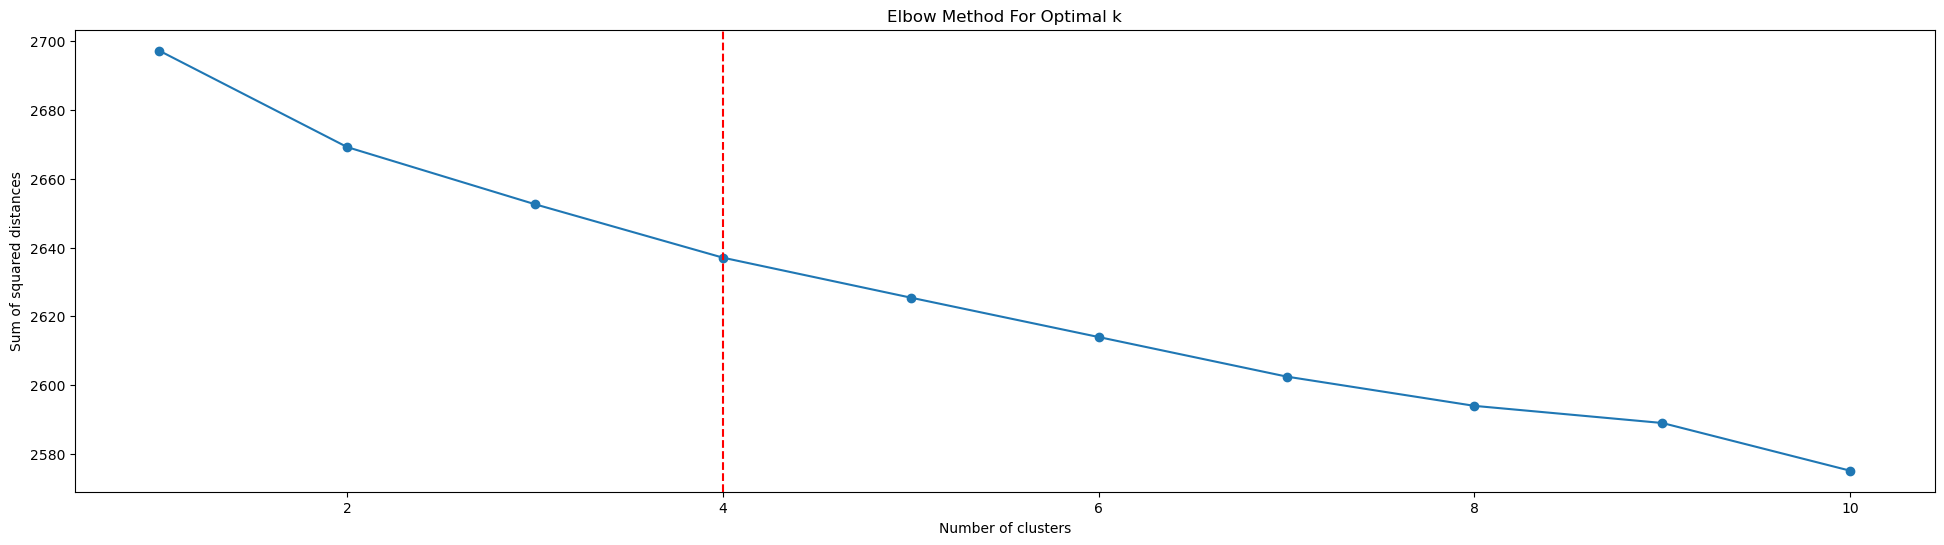

                                                Text  Cluster
0  hi there we will receive our new fiat 500e ico...        1
1  hi there i have ordered a fiat 500e icon on le...        1
2  i had my 2015 fiat 500e shipped from ca a few ...        1
3  the latest fiat 500e la prima designio by kahn...        1
4  is there a way to delete not just unselect a c...        1

Cluster 0
informative,always,video,thank,best,looks,good,love,great,review

Cluster 1
time,thats,battery,new,nice,drive,good,price,buy,love

Cluster 2
better,good,charging,city,mile,small,battery,price,miles,range

Cluster 3
need,mini,make,small,good,vehicles,makes,new,petrol,electric


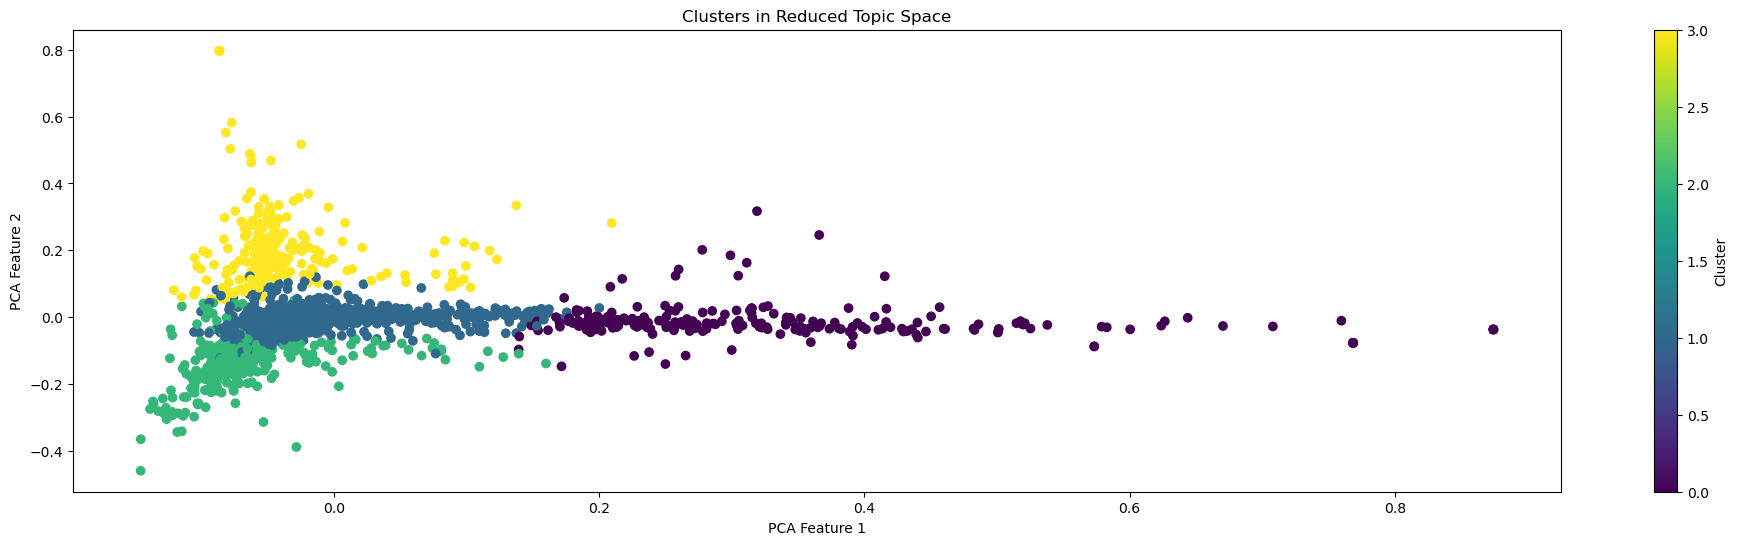


Cluster 0 Summary:
29     apologies if ive missed a thread on this but i...
247    good honest review thanks like the car im in a...
254    712 strangely aroused at this pointanywayconce...
259            what a great reviewer love her wit humour
265    just passing by locking for a review what is t...
284    fabulous review and the reviewer has buckets o...
287    a charismatic car and a charismatic reviewer g...
306    i love the 500 a small city car that is happy ...
321    great review again my wife loves hers and the ...
323    i really really like them looks great on this car
Name: Text, dtype: object

Cluster 1 Summary:
0    hi there we will receive our new fiat 500e ico...
1    hi there i have ordered a fiat 500e icon on le...
2    i had my 2015 fiat 500e shipped from ca a few ...
3    the latest fiat 500e la prima designio by kahn...
4    is there a way to delete not just unselect a c...
5    hello everyone i have bought a fiat 500e icon ...
6    hi all i was wondering if any

In [16]:
# Add custom_stopwords
custom_stopwords_500 = set(stopwords.words('english'))
custom_stopwords_500.update(['car', 'cars', 'uh', 'yes', 'go', 'e', 'oh', 'black', 'grey', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less','fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 
                      'hyundai', 'honda', 'kona', 'kind', 'want', 'mean', 'fat', 'um', 'yeah', 'okay','one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 
                      'going', 'be','much', 'comes','like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually','even', 'however', 'around', 'see', 
                      'know', 'presented', 'example', 'ev', 'evs','im', 'johnny','thanks','jonny']) 

# Define preprocessing function
def preprocess(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords_500]
        return ' '.join(tokens)
    else:
        return ''

# Preprocess the text data
comments_500e['cleaned_text'] = comments_500e['Text'].apply(preprocess)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(comments_500e['cleaned_text'])

# Determine the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(24, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.axvline(x=4, color='red', linestyle='--')  # Add a red line for the optimal number of clusters
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

# Apply KMeans Clustering with optimal clusters determined by Elbow Method
optimal_k = 4  # Replace with the optimal number of clusters determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add the cluster labels to your original DataFrame
comments_500e['Cluster'] = clusters

# Display the DataFrame with the new cluster column
print(comments_500e[['Text', 'Cluster']].head())

# Print the clusters with key words
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    terms = labels
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X_tfidf, clusters, tfidf_vectorizer.get_feature_names_out(), 10)

# Plotting cluster results using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(24, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters in Reduced Topic Space')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Analyze clusters
for cluster_num in range(optimal_k):
    cluster_data = comments_500e[comments_500e['Cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} Summary:")
    print(cluster_data['Text'].head(10))  # Display sample comments from each cluster


In [17]:
# Add sentiment analysis
sid = SentimentIntensityAnalyzer()
comments_500e['Sentiment'] = comments_500e['Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(comments_500e['cleaned_text'])

# Apply KMeans Clustering with optimal clusters determined by Elbow Method
optimal_k = 4  # Replace with the optimal number of clusters determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add the cluster labels to your original DataFrame
comments_500e['Cluster'] = clusters

# Function to get top keywords in each cluster
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    terms = labels
    top_keywords = {}
    for i, r in df.iterrows():
        top_keywords[i] = [terms[t] for t in np.argsort(r)[-n_terms:]]
    return top_keywords

# Function to get top negative words in each cluster
def get_top_negative_words(data, clusters, labels, n_terms=10):
    negative_word_scores = {}
    
    for cluster_num in range(len(set(clusters))):
        cluster_data = data[data['Cluster'] == cluster_num]
        negative_word_scores_cluster = {}
        
        for text in cluster_data['cleaned_text']:
            sentiment_scores = sid.polarity_scores(text)
            if sentiment_scores['compound'] < 0:
                words = text.split()
                for word in words:
                    if word in negative_word_scores_cluster:
                        negative_word_scores_cluster[word] += sentiment_scores['compound']
                    else:
                        negative_word_scores_cluster[word] = sentiment_scores['compound']
        
        sorted_words = sorted(negative_word_scores_cluster.items(), key=lambda item: item[1])[:n_terms]
        negative_word_scores[cluster_num] = [word for word, score in sorted_words]
    
    return negative_word_scores

# Function to get key comments in each cluster
def get_key_comments(data, clusters, num_comments=3):
    key_comments = {}
    for cluster_num in range(len(set(clusters))):
        cluster_data = data[data['Cluster'] == cluster_num]
        sorted_comments = cluster_data.sort_values(by='Sentiment', ascending=False).head(num_comments)
        key_comments[cluster_num] = sorted_comments[['Text', 'Sentiment']].values.tolist()
    return key_comments

# Get top keywords, key comments, and top negative words
top_keywords = get_top_keywords(X_tfidf, clusters, tfidf_vectorizer.get_feature_names_out(), 10)
top_negative_words = get_top_negative_words(comments_500e, clusters, tfidf_vectorizer.get_feature_names_out(), 10)
key_comments = get_key_comments(comments_500e, clusters, 3)

# Print consolidated key figures for each cluster
for cluster_num in range(optimal_k):
    print(f"Cluster {cluster_num} Summary:\n")
    
    print("Top Keywords:")
    print(', '.join(top_keywords[cluster_num]))
    
    print("\nKey Comments:")
    for comment, sentiment in key_comments[cluster_num]:
        print(f"- {comment} (Sentiment: {sentiment})")
    
    avg_sentiment = comments_500e[comments_500e['Cluster'] == cluster_num]['Sentiment'].mean()
    print(f"\nAverage Sentiment Score: {avg_sentiment:.3f}")
    
    print("\nTop Negative Words:")
    print(', '.join(top_negative_words[cluster_num]))
    
    print("\n" + "="*50 + "\n")

/Users/janapawlenczuk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 Summary:

Top Keywords:
informative, always, video, thank, best, looks, good, love, great, review

Key Comments:
- i love the 500 a small city car that is happy being a small city car great review much nicer interior quality and the specs are so good for what it is going to be used for although u are paying more now the 500 makes a great electric city car for the millions of people without loads of kids and large shopping trips etc because we do exist we need more manufacturers thinking like this (Sentiment: 0.9788)
- base model looks great and i am sure the range would be enough for a lot of people a lot of the time its still expensive compared to ice alternatives but new tech often is and this is definitely a good value route into ev ownership great review thanks (Sentiment: 0.9756)
- the fiat 500e ev wins the most yt reviewed car of the week award but you win the best review for information and entertainment imho thanks (Sentiment: 0.9754)

Average Sentiment Score: 0.643



**Cluster 0**

•⁠ ⁠Sample Comments:

This cluster contains positive feedback focusing on the Fiat 500e’s design, user-friendliness, and its appeal as a small electric city car. Reviewers frequently highlight the car’s interior quality, practicality for urban driving, and overall satisfaction with the vehicle's design and performance.

•⁠ ⁠Common Words: ['informative', 'always', 'video', 'thank', 'best', 'looks', 'good', 'love', 'great', 'review']

•⁠ ⁠Average Sentiment: Positive (0.643)

•⁠ ⁠Sentiment Distribution: Largely positive, with many users expressing high satisfaction with the vehicle’s design and functionality.

•⁠ ⁠Negative Keywords: ['review', 'great', 'anthropogenic', 'extinction', 'hell', 'thank', 'need', 'ban', 'toxic', 'burning']

•⁠ ⁠Insights: This cluster shows that users are generally impressed with the Fiat 500e, particularly those who value a well-designed and functional city car. The feedback suggests strong brand loyalty and appreciation for the car's aesthetic and practical improvements, despite its higher price tag.

**Cluster 1**

•⁠ ⁠Sample Comments:

This cluster features discussions about the broader implications of electric vehicle ownership, including environmental impact, charging infrastructure, and comparisons with traditional vehicles. Users also discuss practical experiences and challenges related to EV usage in various environments, such as rural areas or regions with limited charging infrastructure.

•⁠ ⁠Common Words: ['time', 'thats', 'battery', 'new', 'nice', 'drive', 'good', 'price', 'buy', 'love']

•⁠ ⁠Average Sentiment: Neutral (0.241)

•⁠ ⁠Sentiment Distribution: Mixed, with some users expressing optimism about the future of EVs, while others highlight concerns about battery life, charging infrastructure, and the practicality of EVs for everyday use.

•⁠ ⁠Negative Keywords: ['driving', 'battery', 'time', 'buy', 'drive', 'pedal', 'thats', 'could', 'use', 'work']

•⁠ ⁠Insights: This cluster shows a balanced perspective on the Fiat 500e and EVs in general. While there is appreciation for the car's design and the concept of electric driving, there are also significant concerns about the long-term sustainability of EVs, their environmental impact, and the practicality of owning one in less urbanized areas.

**Cluster 2**

•⁠ ⁠Sample Comments:

This cluster includes comments that focus on the Fiat 500e’s range, battery performance, and overall value as an electric city car. Users often discuss the practicality of the 500e for short commutes and city driving, highlighting both its strengths and limitations in terms of range and charging.

•⁠ ⁠Common Words: ['better', 'good', 'charging', 'city', 'mile', 'small', 'battery', 'price', 'miles', 'range']

•⁠ ⁠Average Sentiment: Neutral (0.307)

•⁠ ⁠Sentiment Distribution: Mixed, with users acknowledging the 500e's strengths as a city car while also noting concerns about range, charging time, and the car’s overall value for money.

•⁠ ⁠Negative Keywords: ['range', 'miles', 'price', 'charge', 'isnt', 'small', 'enough', 'problem', 'battery', 'electric']

•⁠ ⁠Insights: This cluster highlights the practicality of the Fiat 500e for urban use, with users appreciating its design and performance for short trips. However, there are concerns about the range, charging infrastructure, and whether the car offers good value for its price, especially for those who may need to drive longer distances.

**Cluster 3**

•⁠ ⁠Sample Comments:

This cluster contains discussions around the long-term sustainability of EVs, particularly focusing on the Fiat 500e. Users express concerns about battery life, recyclability, and the overall environmental impact of electric vehicles compared to traditional petrol or diesel cars. The discussions also touch on the economic aspects of owning an EV.

•⁠ ⁠Common Words: ['need', 'mini', 'make', 'small', 'good', 'vehicles', 'makes', 'new', 'petrol', 'electric']

•⁠ ⁠Average Sentiment: Neutral to Slightly Negative (0.229)

•⁠ ⁠Sentiment Distribution: Mixed to slightly negative, with users showing caution about fully embracing EVs due to concerns about battery longevity, environmental impact, and the cost-effectiveness of EV ownership.

•⁠ ⁠Negative Keywords: ['electric', 'petrol', 'charge', 'new', 'day', 'used', 'right', 'time', 'government', 'thats']

•⁠ ⁠Insights: This cluster reflects a cautious attitude towards electric vehicles, with users weighing the benefits of EVs against concerns about long-term sustainability and cost. While there is appreciation for the Fiat 500e's design and engineering, these users are not fully convinced that EVs are the future, expressing a preference for alternative technologies like hydrogen fuel cells.

#### Customer's journey analysis

In [18]:
# Define the stemmer
stemmer = PorterStemmer()

# Define journey keywords
journey_keywords = {
    'consideration': [
        'considering', 'thinking about', 'interested in', 'exploring', 'hearing about', 'learning about', 
        'reading about', 'looking into', 'researching', 'looking at', 'deciding', 'researching', 
        'evaluating', 'comparing', 'analyzing', 'reviewing', 'debating', 'checking out', 'discover', 
        'learn', 'understand', 'explore', 'notice', 'recognize', 'find', 'seek', 'know', 'identify', 
        'realize', 'consider', 'observe', 'uncover', 'detect', 'read', 'watch', 'listen', 'aware', 
        'interest', 'curiosity', 'investigate', 'look for', 'browse', 'research', 'survey', 'familiarize', 
        'acknowledge', 'perceive', 'enlighten', 'examine', 'discover', 'catch sight of', 'encounter', 
        'gain insight', 'illuminate', 'introduce', 'join', 'participate', 'pay attention', 'probe', 
        'recognize', 'review', 'scan', 'scrutinize', 'search', 'seek out', 'study', 'test', 'understand', 
        'hear about', 'view', 'engage with', 'witness', 'inquire about', 'look into', 'delve into', 
        'get to know', 'survey', 'participate in', 'inform oneself', 'catch wind of', 'unearth', 'inspect', 
        'spot', 'catch glimpse of', 'gain knowledge of', 'contextualize', 'sense', 'learn about', 
        'get acquainted with', 'see', 'be exposed to', 'be mindful of', 'get wind of', 'be conscious of', 
        'note', 'catch', 'perceive', 'digest', 'behold', 'monitor', 'discover', 'detect', 'figure out'
    ],
    'purchase': [
        'just bought', 'just purchased', 'got my new', 'bought', 'shipped', 'purchased', 'ordered', 
        'picked up', 'acquired', 'receiving', 'ordering', 'ordered a', 'buying', 'picking up', 
        'received', 'will receive', 'have ordered', 'loving my new', 'happy with', 'enjoying my', 'i got',
        'satisfied with', 'pleased with', 'delighted with', 'using', 'experiencing', 'after purchase', 'i own',
        'owning', 'owned', 'driving', 'having', 'have ordered', 'leasing', 'lease', 'buy', 'order', 'i ordered',
        'purchase', 'acquire', 'get', 'obtain', 'secure', 'checkout', 'invest in', 'procure', 'take', 
        'reserve', 'add to cart', 'pay for', 'confirm', 'buy now', 'place order', 'complete purchase', 
        'enroll', 'sign up', 'lease', 'book', 'submit order', 'redeem', 'commit to buy', 'purchase online', 
        'make a deal', 'settle on', 'choose', 'pick', 'select', 'go for', 'accept offer', 'agree to buy', 'order',
        'lock in purchase', 'execute transaction', 'cash out', 'shop for', 'bid', 'make payment', 
        'engage services', 'claim', 'rent', 'hire', 'appoint', 'schedule', 'preorder', 'layaway', 
        'put a down payment', 'opt for', 'get hold of', 'settle payment', 'put in order', 'put money down', 
        'agree to terms', 'contract', 'enter into agreement', 'make purchase', 'take ownership', 'wrap up sale', 
        'engage', 'part with money', 'buy in-store', 'sign contract', 'procure services', 'call for delivery', 
        'obtain goods', 'swap for', 'exchange for', 'barter for', 'click to buy', 'press to purchase', 
        'subscribe', 'join membership'
    ],
    'not interested': [
        'not interested', 'do not want', 'not buying', 'never buy', 'not like', 'hate', 
        'not for me', 'would not consider', 'would not consider', 'don care', 'no interest', 
        'waste of money', 'uninterested', 'avoid', 'reject', 'decline', 'dislike', 'no thanks',
        'not a fan', 'not worth', 'not worth it', 'overpriced', 'too expensive', 'would rather not',
        'no need', 'no need', 'would not buy', 'no plan to buy', 'no intention', 'skip', 'waste of time',
        'not convinced', 'not worth the money', 'no value', 'no point', 'not interested in buying',
        'not worth the price', 'not for me', 'pass on this', 'not my style', 'not my thing',
    ]
}

# Function to identify journey stage using exact keyword matching
def identify_journey_stage(text):
    text = text.lower()
    for stage, keywords in journey_keywords.items():
        if any(keyword in text for keyword in keywords):
            return stage
    return 'other'

# Identify the customer journey stage for each comment using the stemmed keywords
comments_500e['Journey_Stage'] = comments_500e['cleaned_text'].apply(identify_journey_stage)

# Print the first few rows to see the results
print(comments_500e[['Text', 'cleaned_text', 'Journey_Stage']].head())


                                                Text  \
0  hi there we will receive our new fiat 500e ico...   
1  hi there i have ordered a fiat 500e icon on le...   
2  i had my 2015 fiat 500e shipped from ca a few ...   
3  the latest fiat 500e la prima designio by kahn...   
4  is there a way to delete not just unselect a c...   

                                        cleaned_text  Journey_Stage  
0  hi receive new icon months ahead schedule prep...       purchase  
1  hi ordered icon lease come march ordered gt pr...  consideration  
2  shipped ca years ago strong things looked plac...       purchase  
3  latest la prima designio kahn specification fr...  consideration  
4  way delete unselect charging schedule ie retur...  consideration  


Journey_Stage
consideration     0.426650
not interested   -0.208812
other             0.198446
purchase          0.230164
Name: Sentiment, dtype: float64


/var/folders/y6/qmf174vs799fh0j8zyjmr8y40000gn/T/ipykernel_56999/4215292522.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = monthly_stage_sentiment_filtered.fillna(method='ffill')


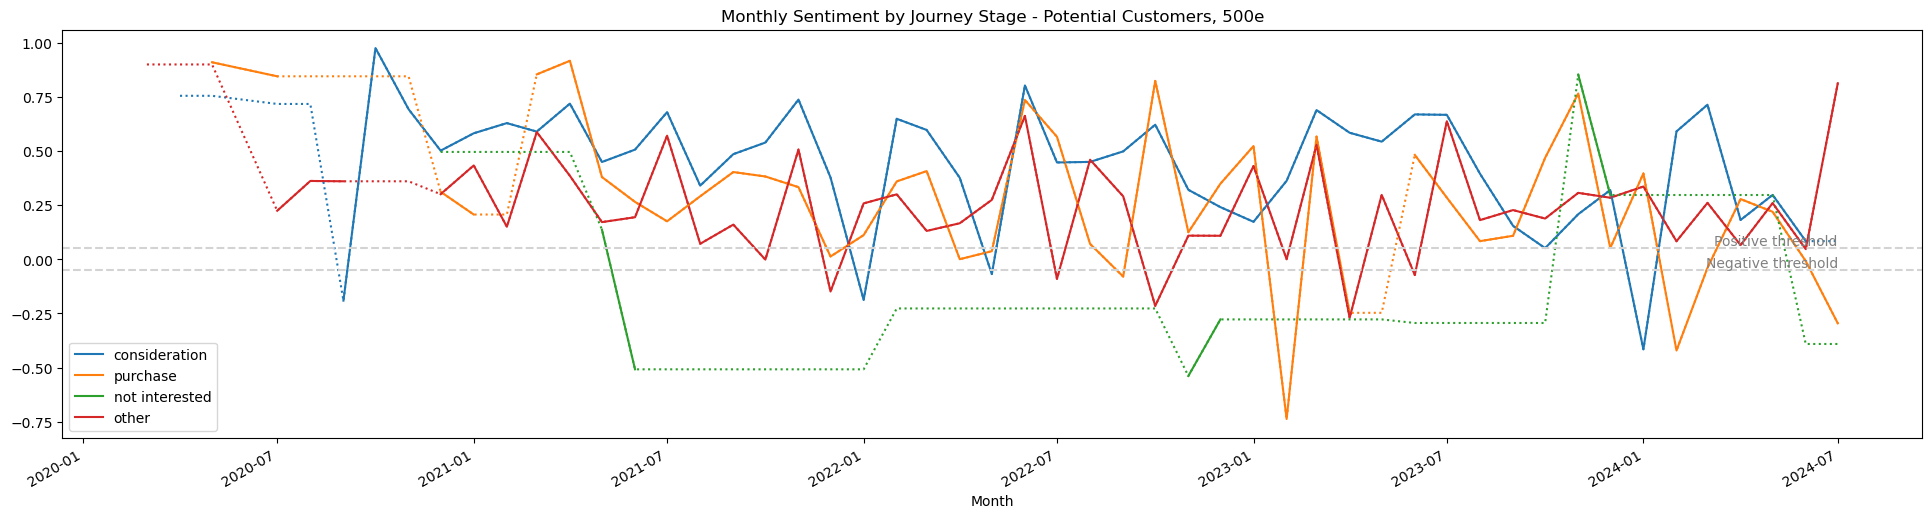

In [19]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()
comments_500e['Sentiment'] = comments_500e['Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Analyze sentiment by journey stage
journey_stage_sentiment = comments_500e.groupby('Journey_Stage')['Sentiment'].mean()
print(journey_stage_sentiment)

# Timeline Analysis
comments_500e['Date'] = pd.to_datetime(comments_500e['Date'])
comments_500e['Month'] = comments_500e['Date'].dt.to_period('M')

# Group comments by stages of the journey and analyze the sentiment and content for each stage
monthly_stage_sentiment = comments_500e.groupby(['Journey_Stage', 'Month'])['Sentiment'].mean()
monthly_stage_sentiment = comments_500e.pivot_table(index='Month', columns='Journey_Stage', values='Sentiment', aggfunc='mean')

# Filter to only include awareness, purchase, and other stages
filtered_stages = ['consideration', 'purchase', 'not interested' ,'other']
available_stages = [stage for stage in filtered_stages if stage in monthly_stage_sentiment.columns]
monthly_stage_sentiment_filtered = monthly_stage_sentiment[available_stages]

# Fill NaNs with last available value
filled_data = monthly_stage_sentiment_filtered.fillna(method='ffill')

# Convert the index to datetime for proper formatting
monthly_stage_sentiment_filtered.index = monthly_stage_sentiment_filtered.index.to_timestamp()
filled_data.index = filled_data.index.to_timestamp()

# Plot the original data without markers
fig, ax = plt.subplots(figsize=(24, 6))
monthly_stage_sentiment_filtered.plot(ax=ax, title='Monthly Sentiment by Journey Stage - Potential Customers, 500e')

# Plot filled data with the same colors but dotted lines
for column in filled_data.columns:
    filled_data[column].plot(ax=ax, linestyle=':', color=ax.get_lines()[filled_data.columns.get_loc(column)].get_color(), legend=False)

# Add threshold lines
plt.axhline(y=-0.05, color='lightgray', linestyle='--')
plt.axhline(y=0.05, color='lightgray', linestyle='--')
plt.text(monthly_stage_sentiment_filtered.index[-1], -0.05, 'Negative threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')
plt.text(monthly_stage_sentiment_filtered.index[-1], 0.05, 'Positive threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')

# Customize the x-axis to show dates in 'yyyy-mm' format
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
solid_line_handles = [handle for handle in handles if isinstance(handle, plt.Line2D) and handle.get_linestyle() == '-']
solid_line_labels = [labels[handles.index(handle)] for handle in solid_line_handles]
ax.legend(solid_line_handles, solid_line_labels)

# Show plot
plt.show()


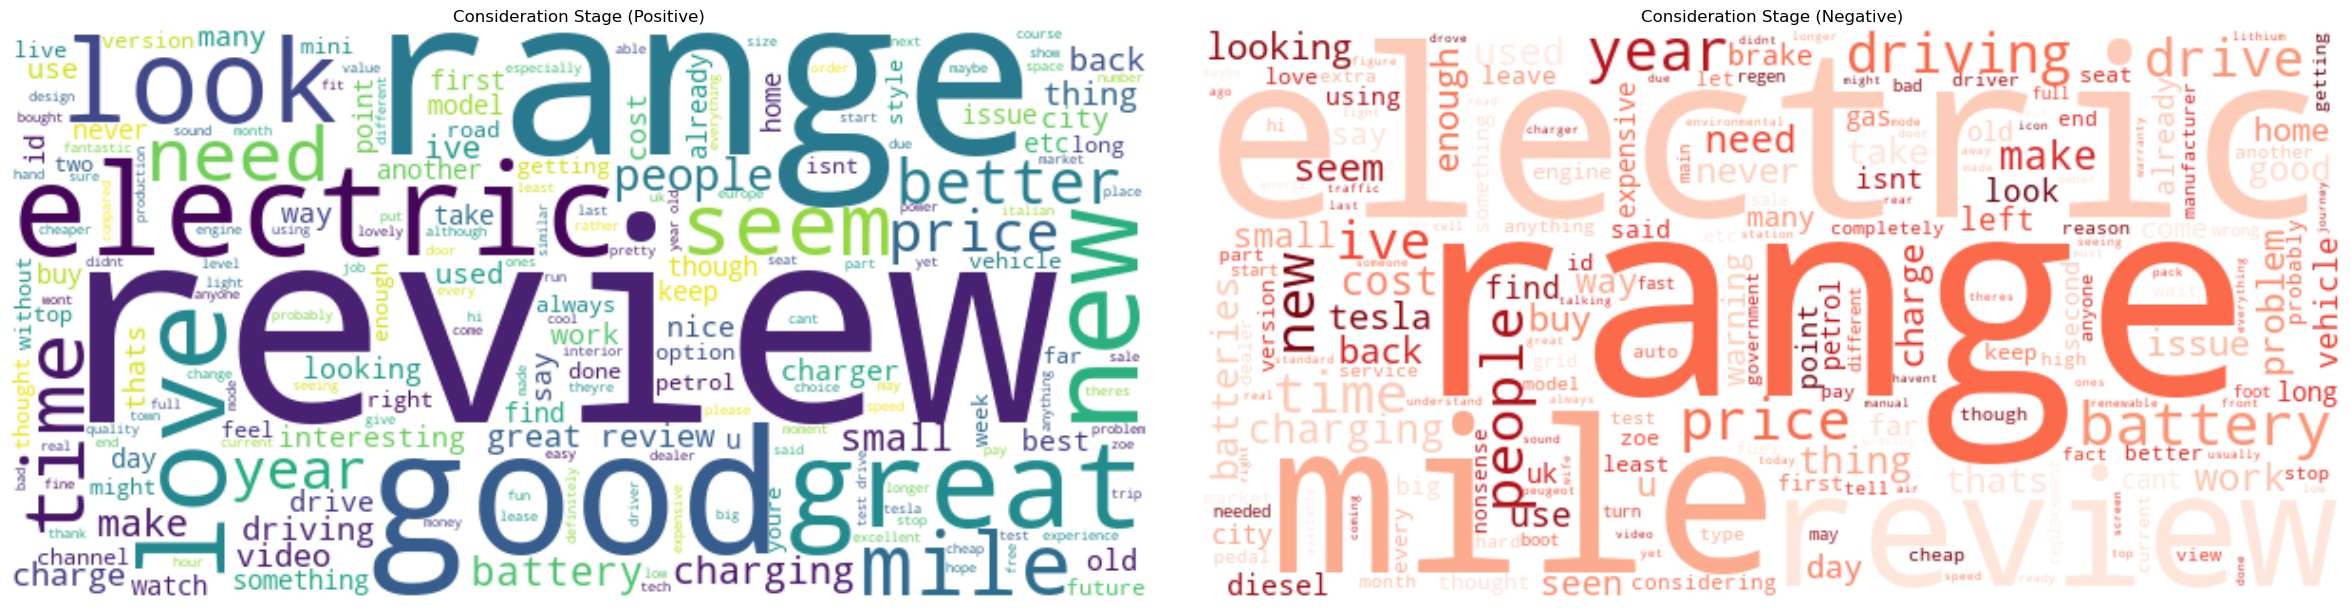

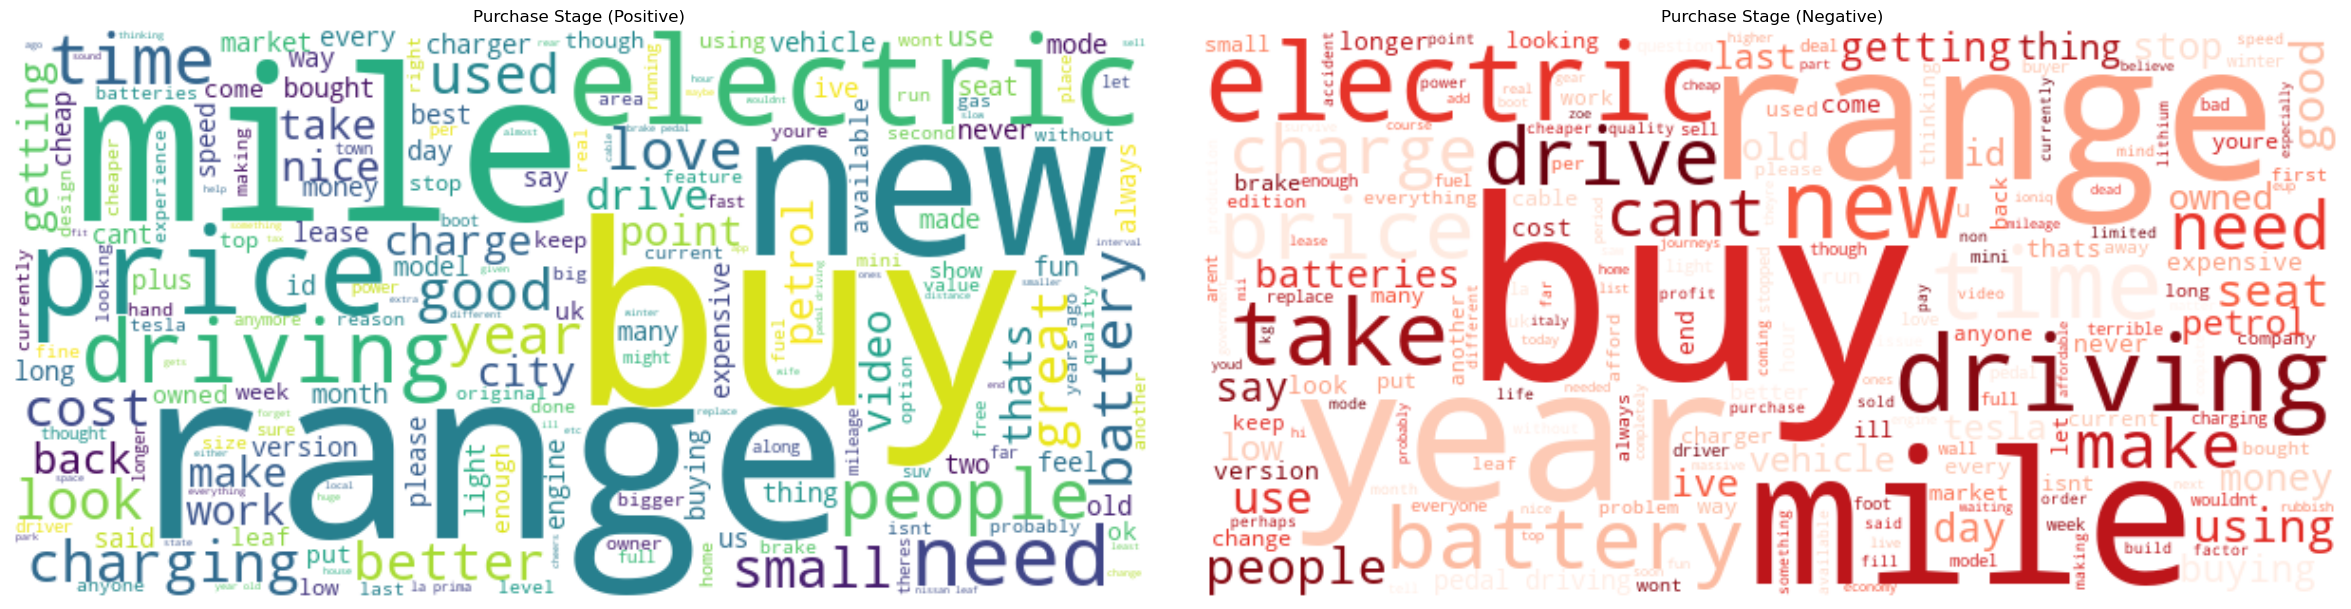

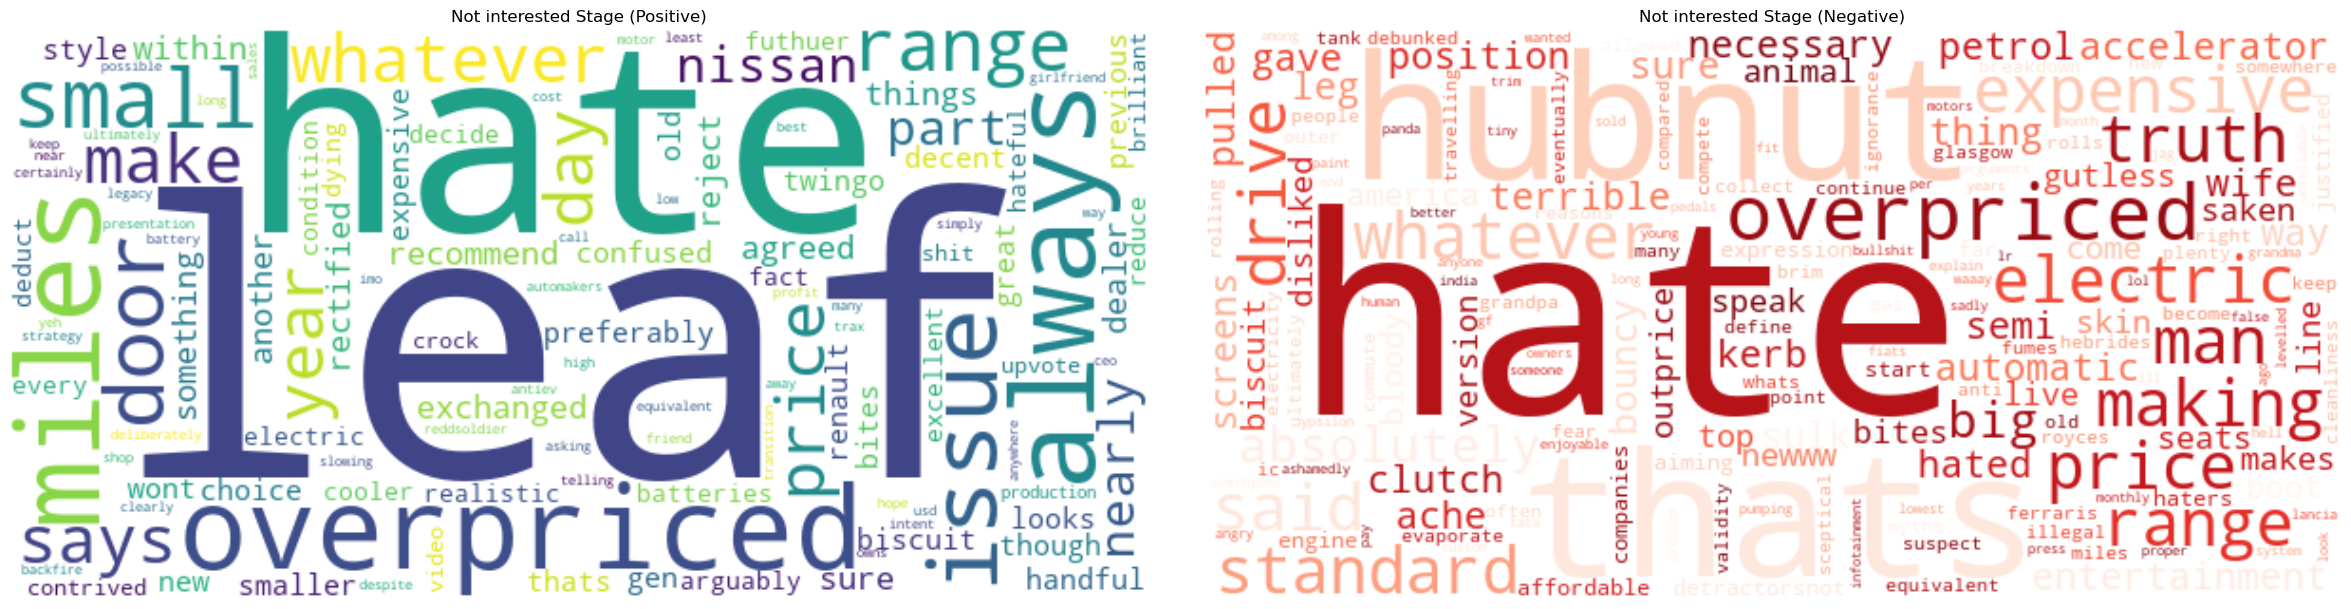

In [20]:
# Function to generate and display word clouds per journey stage and sentiment
def generate_word_clouds_by_sentiment(data, stage):
    # Filter positive and negative data
    positive_data = data[(data['Journey_Stage'] == stage) & (data['Sentiment'] > 0)]
    negative_data = data[(data['Journey_Stage'] == stage) & (data['Sentiment'] <= 0)]
    
    # Generate word clouds with rectangular dimensions
    positive_text = ' '.join(positive_data['cleaned_text'])
    negative_text = ' '.join(negative_data['cleaned_text'])
    
    positive_wordcloud = WordCloud(width=600, height=300, background_color='white').generate(positive_text)
    negative_wordcloud = WordCloud(width=600, height=300, background_color='white', colormap='Reds').generate(negative_text)
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(24, 6)) 
    
    axes[0].imshow(positive_wordcloud, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title(f'{stage.capitalize()} Stage (Positive)')
    
    axes[1].imshow(negative_wordcloud, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title(f'{stage.capitalize()} Stage (Negative)')
    
    plt.tight_layout()
    plt.show()

# Generate word clouds for each journey stage
for stage in journey_keywords.keys():
    generate_word_clouds_by_sentiment(comments_500e, stage)


#### Customer's engagement analysis

In [21]:
# Timeline Analysis
comments_500e['Date'] = pd.to_datetime(comments_500e['Date'])
comments_500e['Month'] = comments_500e['Date'].dt.to_period('M')

# Group comments by stages of the journey and count the number of comments for each stage
monthly_stage_engagement = comments_500e.groupby(['Journey_Stage', 'Month']).size().unstack(fill_value=0)

# Filter to only include awareness, purchase, and other stages
filtered_stages = ['consideration', 'purchase', 'other', 'not interested']
available_stages = [stage for stage in filtered_stages if stage in monthly_stage_engagement.columns]
monthly_stage_engagement_filtered = monthly_stage_engagement[available_stages]

# Adjust display settings to show the entire DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Check the grouped data
print(monthly_stage_engagement)


Month           2020-03  2020-04  2020-05  2020-07  2020-08  2020-09  2020-10  \
Journey_Stage                                                                   
consideration         0        1        0        9        0        2        1   
not interested        0        0        0        0        0        0        0   
other                 1        0        0        4        1        1        0   
purchase              0        0        1        2        0        0        0   

Month           2020-11  2020-12  2021-01  2021-02  2021-03  2021-04  2021-05  \
Journey_Stage                                                                   
consideration         3      365        9        6        5        2       11   
not interested        0        2        0        0        0        0        2   
other                 0      388        7        4        4        3       29   
purchase              0      104        9        0        1        2       14   

Month           2021-06  2

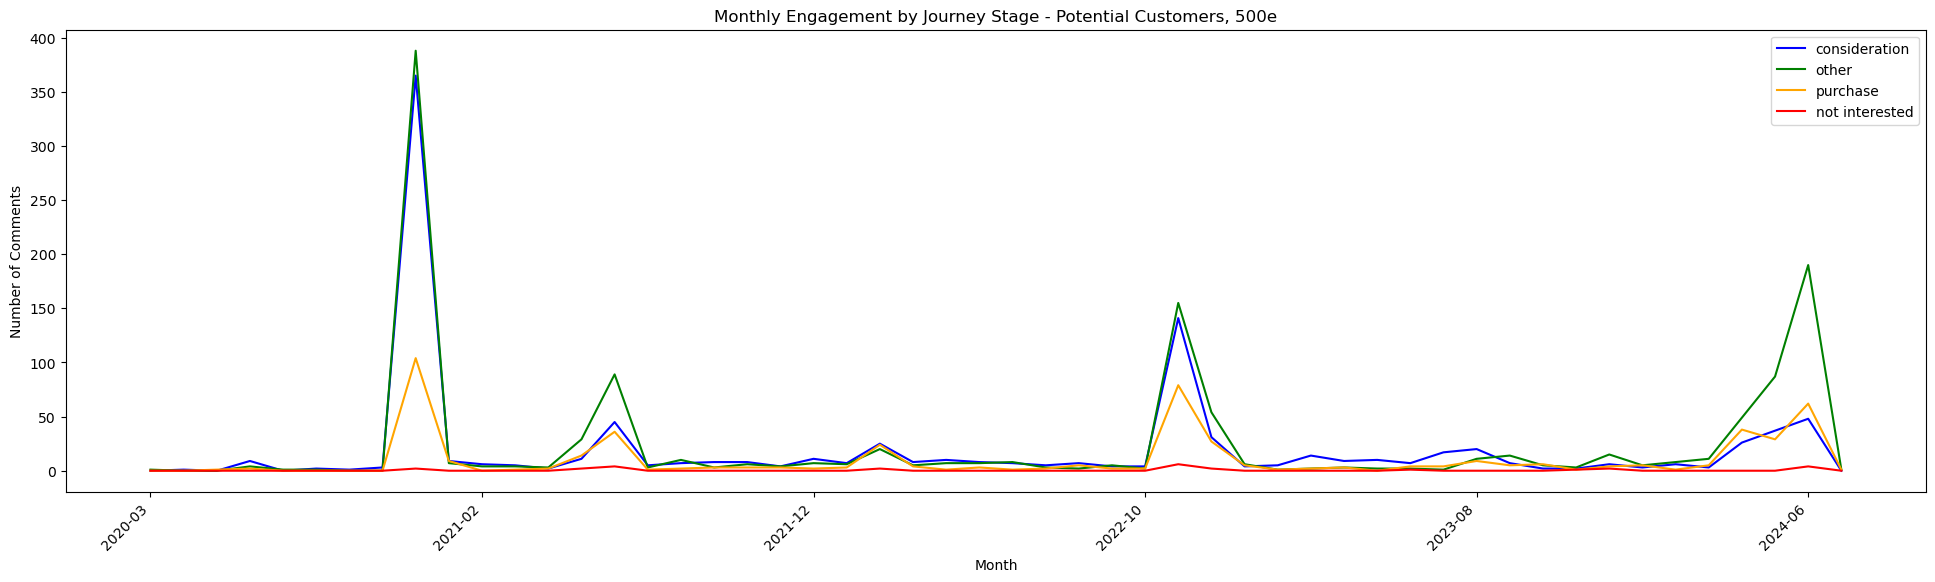

In [22]:
# Monthly engagement data for potential customers of the 500e grouped by stage
data = {
    '2020-03': [0, 1, 0, 0],
    '2020-04': [1, 0, 0, 0],
    '2020-05': [0, 0, 1, 0],
    '2020-07': [9, 4, 2, 0],
    '2020-08': [0, 1, 0, 0],
    '2020-09': [2, 1, 0, 0],
    '2020-10': [1, 0, 0, 0],
    '2020-11': [3, 0, 0, 0],
    '2020-12': [365, 388, 104, 2],
    '2021-01': [9, 7, 9, 0],
    '2021-02': [6, 4, 0, 0],
    '2021-03': [5, 4, 1, 0],
    '2021-04': [2, 3, 2, 0],
    '2021-05': [11, 29, 14, 2],
    '2021-06': [45, 89, 36, 4],
    '2021-07': [5, 3, 1, 0],
    '2021-08': [7, 10, 2, 0],
    '2021-09': [8, 3, 3, 0],
    '2021-10': [8, 6, 3, 0],
    '2021-11': [4, 4, 3, 0],
    '2021-12': [11, 7, 2, 0],
    '2022-01': [7, 6, 3, 0],
    '2022-02': [25, 20, 24, 2],
    '2022-03': [8, 5, 4, 0],
    '2022-04': [10, 7, 1, 0],
    '2022-05': [8, 7, 3, 0],
    '2022-06': [7, 8, 1, 0],
    '2022-07': [5, 3, 2, 0],
    '2022-08': [7, 2, 5, 0],
    '2022-09': [4, 5, 2, 0],
    '2022-10': [4, 2, 2, 0],
    '2022-11': [141, 155, 79, 6],
    '2022-12': [31, 54, 27, 2],
    '2023-01': [4, 6, 5, 0],
    '2023-02': [5, 1, 1, 0],
    '2023-03': [14, 2, 2, 0],
    '2023-04': [9, 3, 3, 0],
    '2023-05': [10, 2, 0, 0],
    '2023-06': [7, 2, 4, 1],
    '2023-07': [17, 1, 4, 0],
    '2023-08': [20, 11, 9, 0],
    '2023-09': [7, 14, 5, 0],
    '2023-10': [2, 5, 6, 0],
    '2023-11': [2, 3, 1, 1],
    '2023-12': [6, 15, 4, 2],
    '2024-01': [3, 5, 5, 0],
    '2024-02': [6, 8, 1, 0],
    '2024-03': [3, 11, 5, 0],
    '2024-04': [26, 49, 38, 0],
    '2024-05': [37, 87, 29, 0],
    '2024-06': [48, 190, 62, 4],
    '2024-07': [0, 1, 1, 0],
}

index = ['consideration', 'other', 'purchase', 'not interested']
monthly_stage_engagement = pd.DataFrame(data, index=index)

# Define custom colors for the stages
custom_colors = {'consideration': 'blue', 'purchase': 'orange', 'other': 'green', 'not interested': 'red'}

# Plotting the data
fig, ax = plt.subplots(figsize=(24, 6))

for stage in monthly_stage_engagement.index:
    monthly_stage_engagement.T[stage].plot(ax=ax, linestyle='-', color=custom_colors[stage], label=stage)

# Adding labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Comments')
ax.set_title('Monthly Engagement by Journey Stage - Potential Customers, 500e')

# Removing x and y grid lines
ax.grid(False)

# Rotate x-axis labels
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Adding legend
ax.legend(title='Journey Stage')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
solid_line_handles = [handle for handle in handles if isinstance(handle, plt.Line2D) and handle.get_linestyle() == '-']
solid_line_labels = [labels[handles.index(handle)] for handle in solid_line_handles]
ax.legend(solid_line_handles, solid_line_labels)

# Show plot
plt.show()
